# KerasPainter - Image Regression in Keras


Inspired by https://github.com/naotokui/ChainerPainter

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
import keras
from PIL import Image
from IPython.display import display, HTML

Using TensorFlow backend.


##  Giving value to following worthless designs using neural networks

* Grandma's futon
* High-sense T-shirts
* old-style storysigns

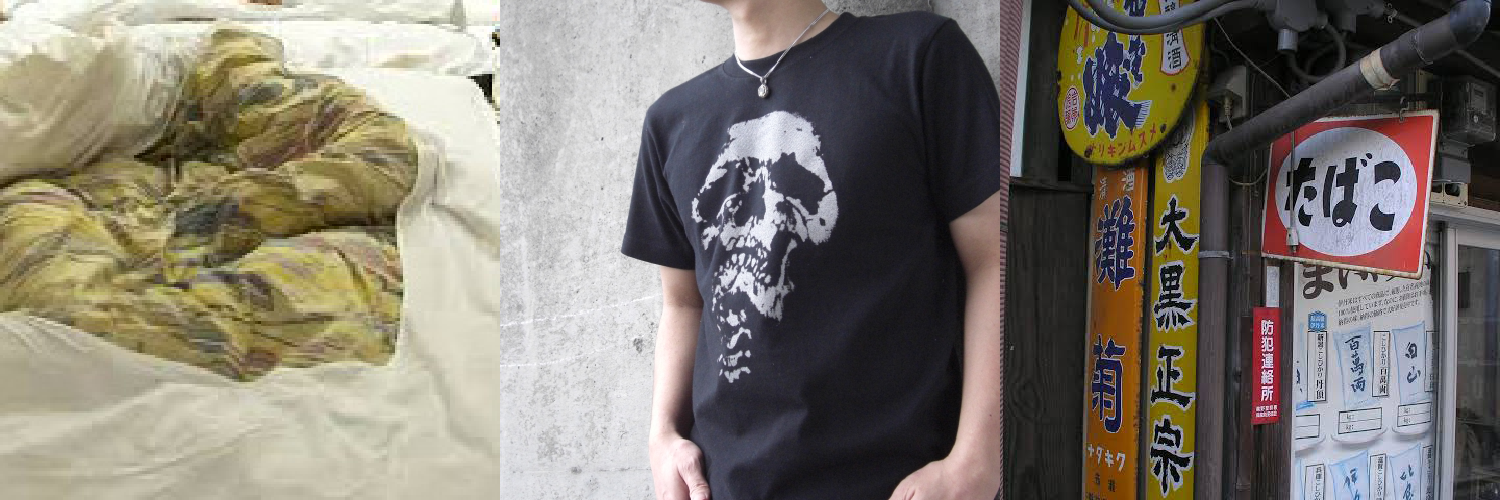

In [2]:
import glob

imgs = []
for file in sorted(glob.glob('images/*')):
    img = Image.open(file).resize((500, 500))
    imgs.append(np.array(img))
    
Image.fromarray(np.hstack(imgs))    

# 1st Example with very simple network

8-fully connected layers. Each layer has 20 neurons. ReLU activation.


input layer: x-y coordinate (2 dimention)  
output layer: RGB colro output (3 dimention)

In [3]:
from keras.layers import Dense, Input
import os
from itertools import product


def get_training_data(img):
    s = img.shape[0]
    indices = np.array(list(product(range(s), range(s))))
    rgb = img[indices[:, 0], indices[:, 1]]
    pos = indices.astype(float) / s - 0.5
    rgb = rgb / 255.0

    x_data = pos
    y_data = rgb

    return x_data, y_data

# training
def train(filename):
    name = os.path.basename(filename)
    name, _ = os.path.splitext(name)
    w = 224

    img = np.array(Image.open(filename).convert("RGB").resize((w, w), Image.BILINEAR))


    x_data, y_data = get_training_data(img)

    model = keras.models.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(2, ))) # 1
    model.add(Dense(20, activation='relu')) # 2
    model.add(Dense(20, activation='relu')) # 3
    model.add(Dense(20, activation='relu')) # 4
    model.add(Dense(20, activation='relu')) # 5
    model.add(Dense(20, activation='relu')) # 6
    model.add(Dense(20, activation='relu')) # 7
    model.add(Dense(20, activation='relu')) # 8
    model.add(Dense(3, activation='sigmoid')) # 9

    model.compile(optimizer='adam', loss='mse')
    
    class Callback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if epoch in [0, 50, 100, 500, 999]:
                img = model.predict(x_data, batch_size=1024)
                img = img.reshape((w, w, 3))
                img = Image.fromarray((img * 255.).astype(np.uint8))
                display(img)
    

    model.fit(
        x_data,
        y_data,
        epochs=1000,
        shuffle=True,
        batch_size=1024,
        callbacks=[Callback()],
        verbose=False
    )
    model.save('models/{}.h5'.format(name))        

./images/grandma_futon.jpeg


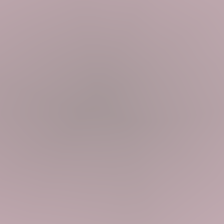

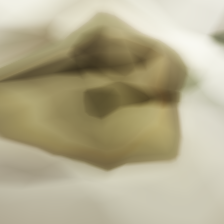

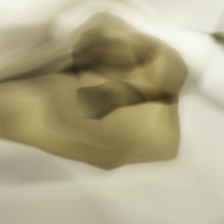

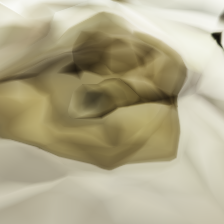

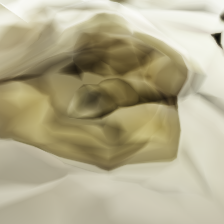

./images/high_sense_t_shirt.png


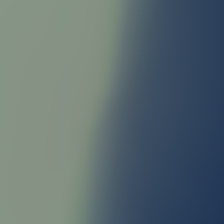

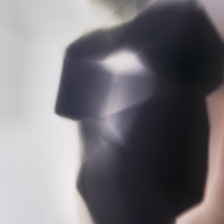

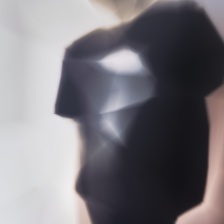

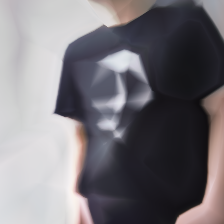

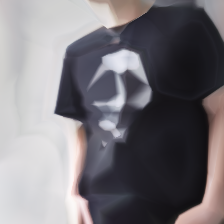

./images/oldstyle_signboard.jpeg


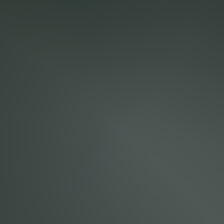

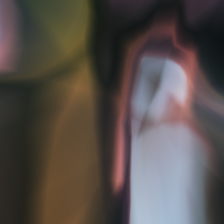

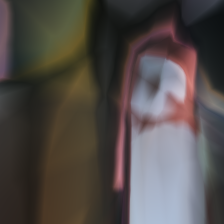

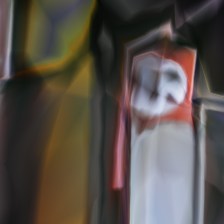

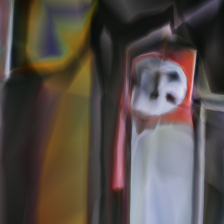

In [4]:
from glob import glob
for filename in sorted(glob('./images/*')):
    print(filename)
    train(filename)

## now things get more interesting
Let's see what happens if you drop some of hidden layers randomly when you feed x-y coordinate data

In [4]:
import keras.backend as K
from keras.layers.merge import Add
from keras.layers import Dense, Lambda, Input
from keras.models import Model
from itertools import product

# create droppable model
input_pos = Input(shape=(2, ))
input_drop = Input(shape=(9, ))

x = input_pos

def blend(index):
    def _blend(args):
        x, y, rate_ = args
        rate = rate_[:, index:index+1]
        return x * rate + y * (1 - rate)
    return _blend

# skip layers
def dropping_layer(x, input_drop, output_length, index):   
    y = Dense(output_length, activation='relu')(x)
    return Lambda(blend(index))([x, y, input_drop])

x = Dense(20, activation='relu')(x)
x = dropping_layer(x, input_drop, 20, 1)
x = dropping_layer(x, input_drop, 20, 2)
x = dropping_layer(x, input_drop, 20, 3)
x = dropping_layer(x, input_drop, 20, 4)
x = dropping_layer(x, input_drop, 20, 5)
x = dropping_layer(x, input_drop, 20, 6)
x = dropping_layer(x, input_drop, 20, 7)
x = Dense(3, activation='sigmoid')(x)

model = Model(inputs=[input_pos, input_drop], outputs=[x])        


def test(filename, drop_layers=[3, 7], drop_rate=1.0, resize=1):
    name = os.path.basename(filename)
    name, _ = os.path.splitext(name)
    model.load_weights('models/{}.h5'.format(name))
    return test_model(model, drop_layers, drop_rate, resize)
    
    
def test_model(model, drop_layers=[3, 7], drop_rate=1.0, resize=1):
    name = os.path.basename(filename)
    name, _ = os.path.splitext(name)    
    w = 224
    
    # scale input xy coordinate so that you get bigger 
    s = w * resize
    pos = np.array(list(product(range(s), range(s))))
    pos = pos / s - 0.5
    drop = np.zeros((len(pos), 9))

    # define drop
    for i in drop_layers:    
        drop[:, i] = drop_rate
    
    img = model.predict([pos, drop], batch_size=1024)
    img = img.reshape((s, s, 3))
    img = Image.fromarray((img * 255.).astype(np.uint8))

    return img

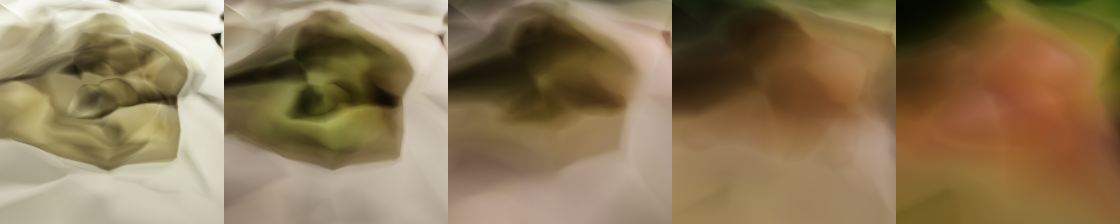

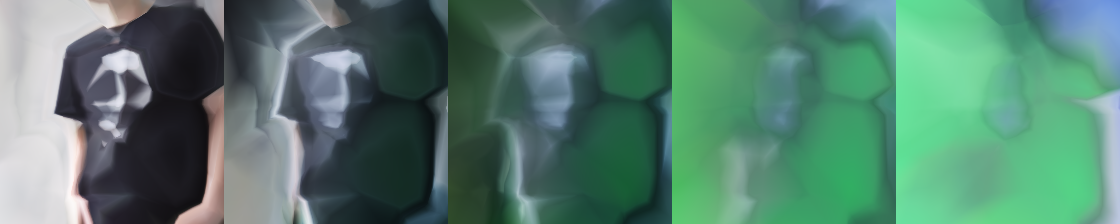

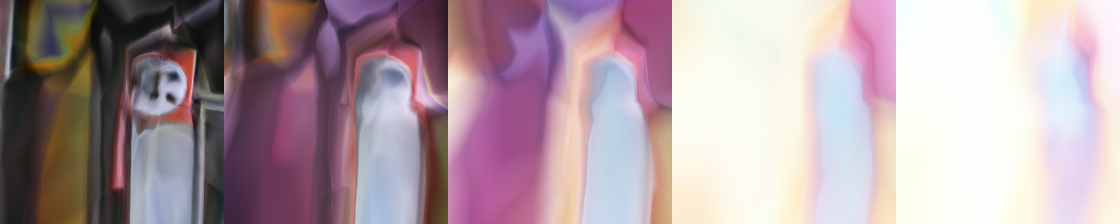

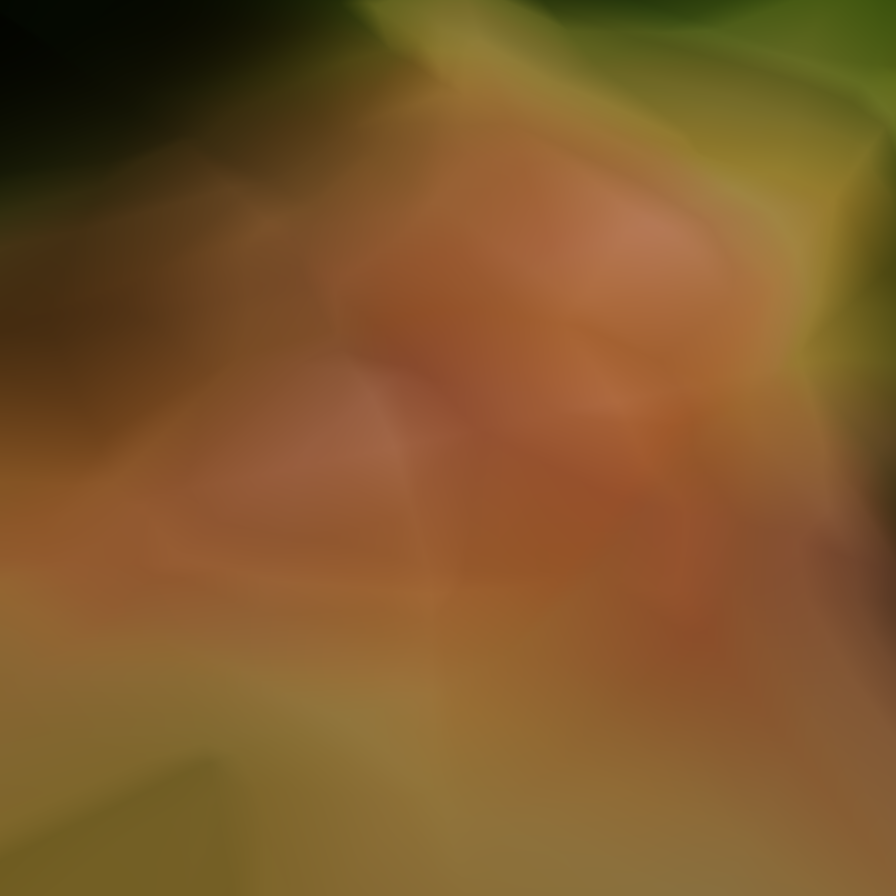

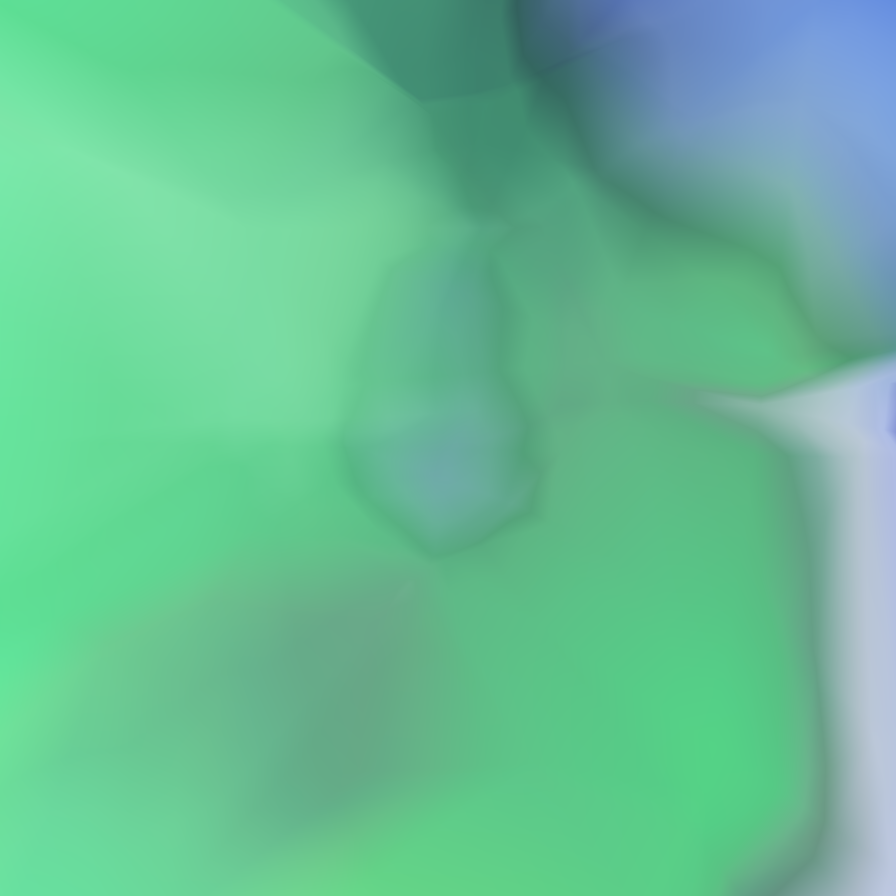

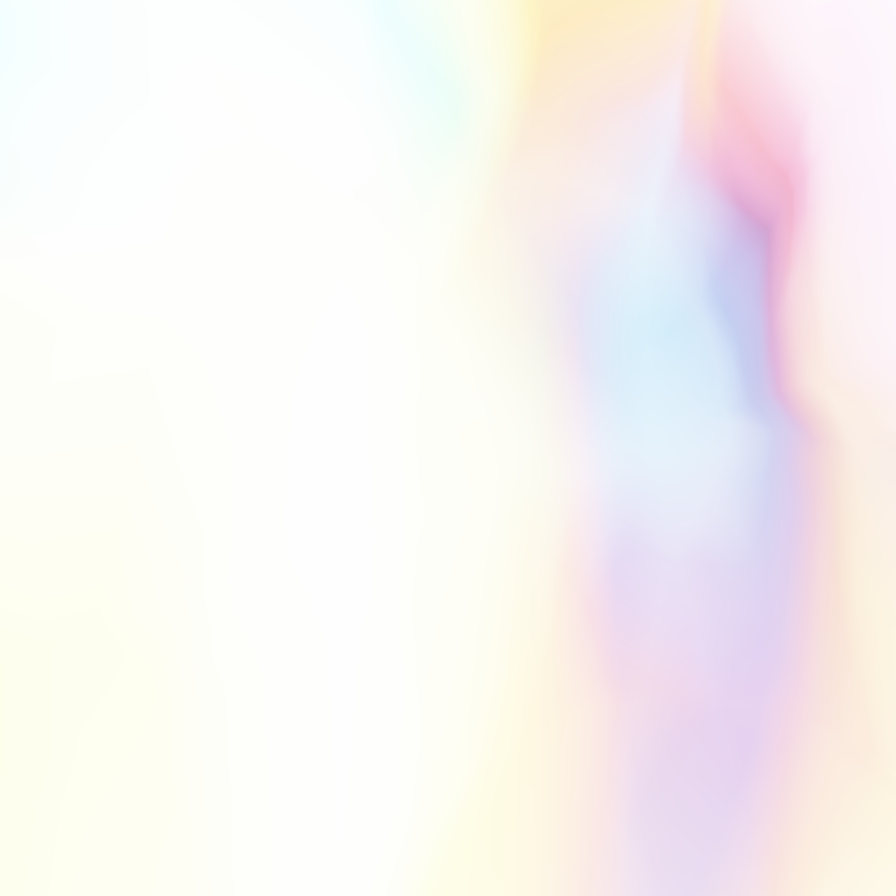

In [6]:
from glob import glob
import os

for filename in sorted(glob('./images/*')):
    imgs = []
    for i in range(5):
        img = test(filename, drop_rate=i/4)    
        imgs.append(np.array(img))
    display(Image.fromarray(np.hstack(imgs)))
    
for filename in sorted(glob('./images/*')):
    img = test(filename, resize=4)    
    display(img)

## finally create movie by interpolating layer weights

In [9]:
import glob
from tqdm import tqdm
from scipy.interpolate import interp1d

out_dir = "./results/background/"    
os.system('mkdir -p {out_dir}/frames'.format(
    out_dir=out_dir))

filenames = list(sorted(glob.glob('./images/*')))

np.random.seed(20)
np.random.shuffle(filenames)

def get_name(filename):
    name = os.path.basename(filename)
    name, _ = os.path.splitext(name)
    return name

# set key points to create movies

wss = []
poss = []

for index, filename in enumerate(filenames[-1:] + filenames + filenames[:3]):    
    pos = index - 1
    name = get_name(filename)
    model.load_weights(f'./models/{name}.h5')
    
    ws = model.get_weights()
    
    for index, w in enumerate(ws):
        if len(wss) <= index:
            wss.append([])
        wss[index].append(w)
    
    poss.append(pos)

fs = []

for ws in wss:
    fs.append(interp1d(np.array(poss), np.array(ws), kind="cubic", axis=0))        

In [ ]:
# make movie frames

from tqdm import tqdm

steps = 30 * 5 # 5 sec per image
counter = 0

drop = np.zeros((9, ), dtype=float)
drop[3] = 1
drop[7] = 1

for x in tqdm(np.arange(0, len(filenames), 1.0/steps)):
    weights = [ f(x) for f in fs ]
    model.set_weights(weights)
    img = test_model(model, resize=4)
    img.save(f"movie/frames/{counter:05d}.png")
    
    counter += 1

 92%|█████████▏| 413/450 [13:11<01:09,  1.89s/it]

In [ ]:
!ffmpeg -i ./movie/frames/%05d.png -r 30 -vcodec libx264 -pix_fmt yuv420p ./movie/animation.mp4 -y

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('./movie/animation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))